In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from sklearn import linear_model as lm
from sklearn import ensemble
from sklearn import metrics
from sklearn.manifold import TSNE
import xgboost as xgb 
from sklearn import svm
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD
import config
%matplotlib inline

## Loading data

In [42]:
X_train_Tfidf = pd.read_csv('features/X_train_Tfidf.csv.gz')
X_test_Tfidf = pd.read_csv('features/X_test_Tfidf.csv.gz')
X_train_lda = pd.read_csv('features/X_train_lda.csv.gz')
X_test_lda = pd.read_csv('features/X_test_lda.csv.gz')
X_train_word2vec = pd.read_csv('features/X_train_word2vec.csv.gz')
X_test_word2vec = pd.read_csv('features/X_test_word2vec.csv.gz')
y_train = pd.read_csv('features/y_train.csv.gz')
y_test = pd.read_csv('features/y_test.csv.gz')

In [28]:
X_train_Tfidf.columns = ['tfidf_{}'.format(i) for i in range(1000)]
X_test_Tfidf.columns = ['tfidf_{}'.format(i) for i in range(1000)]
X_train_lda.columns = ['lda_{}'.format(i) for i in range(100)]
X_test_lda.columns = ['lda_{}'.format(i) for i in range(100)]
X_train_word2vec.columns = ['word2vec_{}'.format(i) for i in range(200)]
X_test_word2vec.columns = ['word2vec{}'.format(i) for i in range(200)]

In [103]:
X_train = pd.concat([X_train_Tfidf, X_train_lda, X_train_word2vec, y_train], axis=1)
X_test = pd.concat([X_test_Tfidf, X_test_lda, X_test_word2vec, y_test], axis=1)

In [104]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [105]:
y_train = X_train['y']
y_test = X_test['y']

In [106]:
X_train.drop('y', inplace=True, axis=1)
X_test.drop('y', inplace=True, axis=1)

## TSNE

In [215]:
tsne = TSNE()
points = tsne.fit_transform(X_train[:5000])

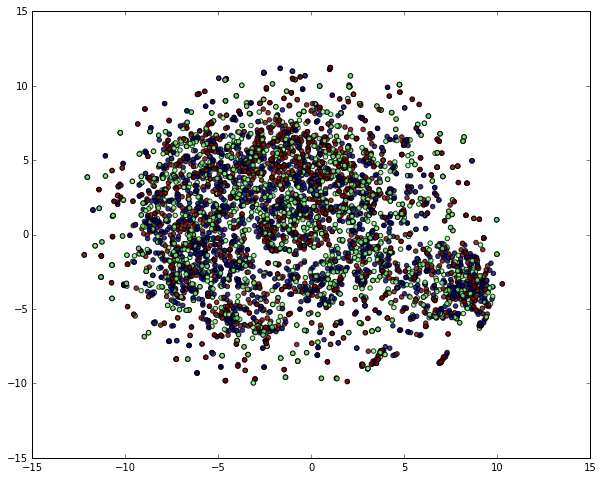

In [222]:
plt.figure(figsize=(10, 8))
plt.scatter(points[:, 0], points[:, 1], c=y_train[:5000], alpha=0.8)

## Models

### Logistic regression

In [107]:
lr = lm.LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
lr.score(X_test, y_test)

0.42297587771674228

In [159]:
pred_lr = lr.predict(X_test)

### Gradient boosting

In [156]:
gb = ensemble.GradientBoostingClassifier(n_estimators=600)
gb.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [158]:
gb.score(X_test, y_test)

0.43037974683544306

In [157]:
pred_gb = gb.predict(X_test)

### Random Forest

In [160]:
rf = ensemble.RandomForestClassifier(n_estimators=600)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [161]:
rf.score(X_test, y_test)

0.41700501552424168

In [162]:
pred_rf = rf.predict(X_test)

### Neural Net (1 hidden)

In [109]:
y_train_cat = np_utils.to_categorical(y_train, 3)
y_test_cat = np_utils.to_categorical(y_test, 3)

In [138]:
model = Sequential()
model.add(Dense(512, input_shape=(1300,)))
model.add(Activation(PReLU()))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation(PReLU()))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [141]:
%%time
history = model.fit(X_train.values, y_train_cat,
                    nb_epoch=6, batch_size=512,
                    verbose=1, validation_split=0.1, )

Train on 15071 samples, validate on 1675 samples
Epoch 1/6
15071/15071 [==============================] - 2s - loss: 1.0362 - acc: 0.4531 - val_loss: 1.0448 - val_acc: 0.4340
Epoch 2/6
15071/15071 [==============================] - 2s - loss: 1.0284 - acc: 0.4655 - val_loss: 1.0456 - val_acc: 0.4281
Epoch 3/6
15071/15071 [==============================] - 2s - loss: 1.0196 - acc: 0.4681 - val_loss: 1.0459 - val_acc: 0.4316
Epoch 4/6
15071/15071 [==============================] - 2s - loss: 1.0102 - acc: 0.4773 - val_loss: 1.0421 - val_acc: 0.4478
Epoch 5/6
15071/15071 [==============================] - 2s - loss: 1.0007 - acc: 0.4881 - val_loss: 1.0388 - val_acc: 0.4478
Epoch 6/6
15071/15071 [==============================] - 2s - loss: 0.9908 - acc: 0.4990 - val_loss: 1.0437 - val_acc: 0.4328
CPU times: user 30.9 s, sys: 27.2 s, total: 58 s
Wall time: 15.9 s


In [142]:
score = model.evaluate(X_test.values, y_test_cat,
                       batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

4096/4187 [============================>.] - ETA: 0sTest score: 1.0629300278
Test accuracy: 0.42751373309


In [155]:
pred_nn = model.predict_classes(X_test.values, batch_size=512)

4187/4187 [==============================] - 0s     


## Ensemble 

In [244]:
pred_ = np.vstack((pred_lr, pred_rf, pred_gb, pred_gb, pred_nn, pred_nn)).T

In [245]:
pred = np.array(np.median(pred_, axis=1), dtype='int')

In [246]:
metrics.accuracy_score(y_test, pred)

0.43014091234774299

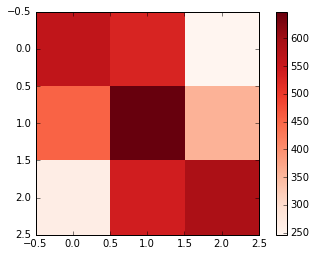

In [204]:
matr = metrics.confusion_matrix(y_test, pred)
plt.imshow(matr, interpolation='nearest', cmap=plt.cm.Reds)
plt.colorbar()

In [247]:
y_test[:10]

0    1
1    1
2    0
3    0
4    1
5    2
6    0
7    0
8    1
9    2
Name: y, dtype: int64

In [248]:
pred_[:10]

array([[ 0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  2.,  2.,  2.,  2.],
       [ 0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  2.,  2.,  0.,  0.],
       [ 1.,  1.,  2.,  2.,  1.,  1.],
       [ 1.,  1.,  2.,  2.,  1.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  1.,  1.]])

In [250]:
print(metrics.classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.44      0.41      0.42      1337
          1       0.38      0.44      0.41      1459
          2       0.49      0.44      0.46      1391

avg / total       0.43      0.43      0.43      4187

